In [225]:
import graphviz
from graphviz import Digraph 
import math 
import random 

In [284]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other): # other + self
        return self + other
    def  __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    def __rmul__(self,other):
        return self * other
    def __pow__(self,other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self, ), f'**{other}') 
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    def __truediv__(self,other):
        return self * other**-1
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        return out 
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a * b;e.label='e'
d = e + c;d.label='d'
f = Value(-2.0, label='f')
L = d * f;L.label='L'
print(L)
print(d)
print(d._prev)
print(d._op)


Value(data=-8.0)
Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}
+


In [256]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [257]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op,label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


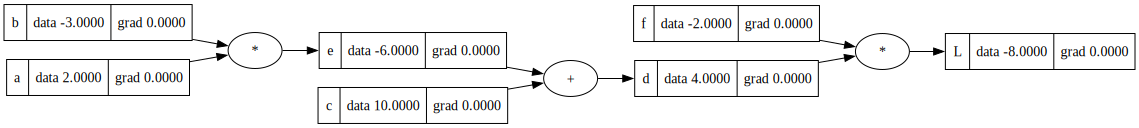

In [258]:
draw_dot(L)

In [212]:
# a simulated forward pass, nudging all of the values by h, to influence L. 
a.data += 0.01 + a.grad
b.data += 0.01 + b.grad
c.data += 0.01 + c.grad
f.data += 0.01 + f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-35.959498999999994


# L = d * f

dL/dd =? f
    *doing this by hand makes it a little more intuitive
    -8.0/4.0 = -2 
dL/df =? d 
    -8.0/-2.0 = 4.0 
#the gradiant of 
(f(x+h)-f(x))/h

((d+h)*f - d*f) / h 
(d*f + h*f - d*f) / h 
h*f/f
f 
--- --- ---

how do we derive a node that is not connected to L? Node e for example
---the chain rule or dz/dx = dz/dy * dy/dx 
      --- if a car travels twice as fast as a bicycle, and the bicycle travels
          4times faster than a man, then the car travels 2 * 4 = 8 times faster
          than the man
dd / dc = 1.0
dd / de = 1.0 

want -> dL/ dc = (dL/dd) * (dd/dc) = -2.0

know -> dL / dd = -2.0
        dd/ dc = 1.0
--- --- ---
dL / de = -2.0 
dL / da = (dL / de) * (de * da)
dL / da = (-2.0) * (-3.0)
dL / db = (-2.0) * (2.0) 


In [213]:
L.grad = 1.0
#d will be
d.grad = -2.0 
f.grad = 4
#the derivative of a plus function is always 1, so a plus node simple routes
    #the gradiant to the leaf nodes
c.grad = -2.0 
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [214]:
#this function serves as a way to manually test the evaluation of the gradiant.
#In other words, add h to a value and see what the resulting output will be
#does it match the expected values calculated by hand in the markdown above
#commented sections show examples, uncomment d and comment out the starting value and see what changes in the gradiant

def test():
    h = 0.001
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a * b;e.label='e'
    d = e + c;d.label='d'
    f = Value(-2.0, label='f')
    L = d * f;L.label='L'
    L1 = L.data
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a * b;e.label='e'
    d = e + c;d.label='d'
    #d.data += h
    f = Value(-2.0, label='f')
    #f = Value(-2.0 + h, label='f')
    L = d * f;L.label='L'
    L2 = L.data 
    
    print((L2 - L1)/h)
test()

0.0


Building a MLP

In [215]:
#inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#w1 and w2 are the weights of the model 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#b is the bias of the model, this particular value is chosen to make the numbers nice and neat 
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
#the math of this simply, x1*w2 + x2w2 + b 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
#n is the 'cell body' of the neuron, applying our activation function determines if it fires
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh();o.label='o'

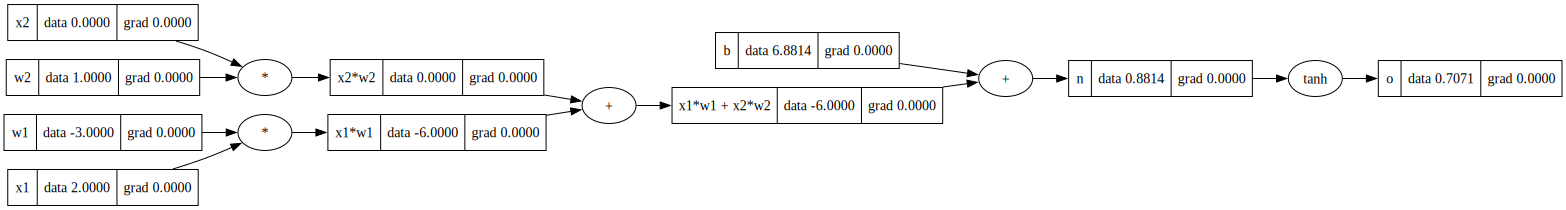

In [216]:
draw_dot(o)

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1w1.grad = 0.5
x2w2.grad = 0.5

In [217]:
#since these are the result of an addtion function, their grad is equal to the parent, n

In [218]:
# o = tanh(n)
# this is simplified derviative calculation for the activation function,tanh
#do/dn = 1 - o**2
#so do/dn = 1-0.7071**2 = 0.5

In [219]:
1 - o.data**2

0.4999999999999999

Applying the _backward functions to do automatic backprop

applying topological sort to the network so that it is more chain like

In [220]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo


[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [221]:
o.backward()

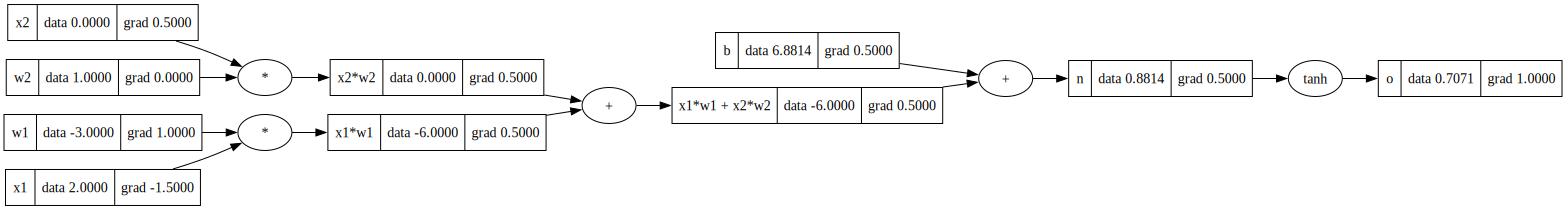

In [222]:
draw_dot(o)

lets do it in pytorch

In [223]:
import torch
x1= torch.Tensor([2.0]).double();x1.requires_grad = True
x2= torch.Tensor([0.0]).double();x2.requires_grad = True
w1= torch.Tensor([-3.0]).double();w1.requires_grad = True
w2= torch.Tensor([1.0]).double();w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();b.requires_grad = True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w2.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 0.0


In [341]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.8984773057299664)

In [342]:
n.parameters()

[Value(data=-0.6938058001021727),
 Value(data=0.8723879719570886),
 Value(data=0.8410091474794561),
 Value(data=0.23625228271709053),
 Value(data=0.6410779591886078),
 Value(data=0.18874617887020184),
 Value(data=-0.625772876512567),
 Value(data=-0.7341394028058292),
 Value(data=0.20825375461297924),
 Value(data=-0.14140802593180268),
 Value(data=-0.19482416821022008),
 Value(data=-0.42742809080830435),
 Value(data=-0.2750240419567742),
 Value(data=-0.2674904599099357),
 Value(data=-0.8434377935384256),
 Value(data=0.22530865295960134),
 Value(data=0.2861455856170352),
 Value(data=-0.6672786721834001),
 Value(data=0.3352762223793042),
 Value(data=-0.13052870711497966),
 Value(data=0.4234118888769347),
 Value(data=-0.06724995304613102),
 Value(data=0.9816145418165023),
 Value(data=0.480682163169176),
 Value(data=0.1054873481560723),
 Value(data=0.6674395416825989),
 Value(data=-0.15476594822236134),
 Value(data=0.9780131896122615),
 Value(data=0.655292522692033),
 Value(data=0.698278028

In [343]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [344]:
for k in range(10):
    #forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
    #backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    #update 
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 3.8613975348816085
1 3.806920691674944
2 3.660821772339974
3 2.6899229757201137
4 0.18876376792506167
5 0.0938580930548375
6 0.07550240753055376
7 0.06447337480259971
8 0.05669723825280239
9 0.05077671017765692


In [345]:
ypred

[Value(data=0.8854470383616005),
 Value(data=-0.8516683734968153),
 Value(data=-0.93310849889593),
 Value(data=0.8942759023850654)]

Value(data=0.019979255238618064)